# Rock Classifier: #2 Image Augmentation
The aim of this series of notebooks is to experiment with different image classification models. I will use the images from Kaggle's [Rock Classification Dataset](https://www.kaggle.com/datasets/salmaneunus/rock-classification). 

This notebook will address the class imbalance by augmenting images from classes with a lower sample size.

In [32]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import splitfolders

# Augment images
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image

In [33]:
DATA_DIR = "../img/Dataset/"
img_data = {}

for folder in os.listdir(DATA_DIR):
    img_path = DATA_DIR + folder + '/'
    img_data[folder] = [img_path + img for img in os.listdir(img_path)]

Recall from the previous notebook that we have significantly lower number of images for certain classes.

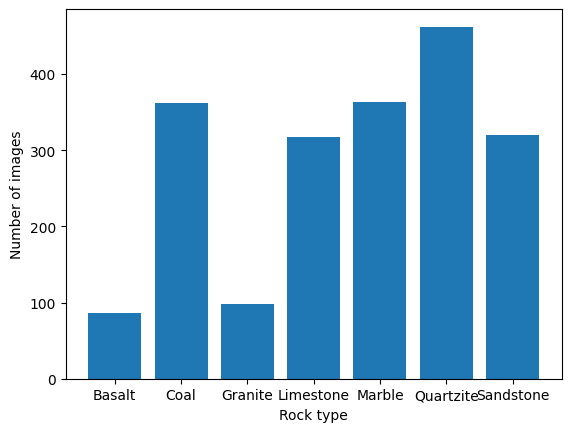

In [35]:
num_img = [len(v) for k,v in img_data.items()]
plt.bar(img_data.keys(), num_img)
plt.ylabel('Number of images')
plt.xlabel('Rock type')
plt.show()

The disparity also exists in the broader classification of these rocks.

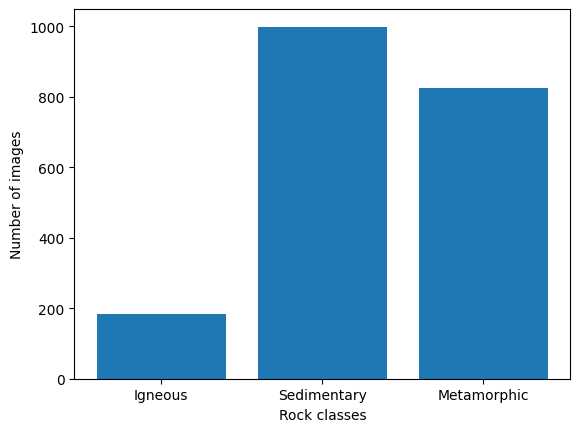

In [36]:
rock_classes = {
    "Igneous": len(img_data['Basalt']) + len(img_data['Granite']),
    "Sedimentary": len(img_data['Limestone']) + len(img_data['Sandstone']) + len(img_data['Coal']),
    "Metamorphic": len(img_data['Quartzite']) + len(img_data['Marble'])
}

plt.bar(rock_classes.keys(), rock_classes.values())
plt.ylabel('Number of images')
plt.xlabel('Rock classes')
plt.show()

First I will separate out the validation and testing data to reduce overfitting. Since the smallest sample size is around 100 images, I will hold out 20 images for the validation and 20 for testing, leaving at the least around 60 images for augmenting.

In [ ]:
DATA_DIR = "../img/Dataset/"
OUTPUT_DIR = "../img/output_test/"

splitfolders.fixed(
            DATA_DIR,
            output=OUTPUT_DIR,
            seed=1337,
            fixed=(20, 20),
        )

As we want the model to learn to discern patterns from a diverse number of images, we will increase the number of images by augmenting them using a combination of the following:

- Randomly rotating images
- Converting images to grey scale
- Randomly cropping images
- Adding blur
- Changing image saturation and brightness
- Flipping images

The basalt and granite rock types, which have the lowest number of images, will have roughly 4 augmented versions of each image. This number of copies is reasonable considering the different augmentations we will apply.

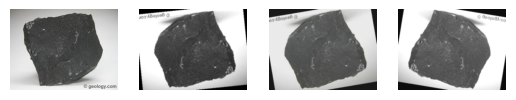

In [37]:
image_transforms = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomGrayscale(0.5),
        transforms.RandomAdjustSharpness(0.5),
        transforms.ColorJitter(0.4, 0.4, 0.4),
        transforms.GaussianBlur(3),
        transforms.ToTensor()
    ]
)

img = Image.open(img_data['Basalt'][0])
fig, axarr = plt.subplots(1,4)
aug_test = [image_transforms(img).permute(1, 2, 0) for i in range(3)]
for ax, im in zip(axarr, [img]+aug_test):
    ax.imshow(im)
    ax.axis('off')
plt.show()


I will create augmented images to match the class with the most images.

In [28]:
train_data = {}

for folder in os.listdir(OUTPUT_DIR+'train/'):
    img_path = OUTPUT_DIR+'train/' + folder + '/'
    train_data[folder] = [img_path + img for img in os.listdir(img_path)]

max_num_img = max([len(v) for k,v in train_data.items()])
print(f"Number of images in largest class: {max_num_img}")

In [38]:
for folder, path_list in train_data.items():
    if len(path_list) < max_num_img:
        sets = (max_num_img-len(path_list)) // len(path_list)
        mod = (max_num_img-len(path_list)) % len(path_list)
        for i, path in enumerate(path_list):
            img = Image.open(path)
            img = img.convert('RGB')
            sets_iter = sets + 1 if i < mod else sets
            for k in range(sets_iter):
                save_image(image_transforms(img), f'{OUTPUT_DIR}/train/{folder}/augmented_{i}_{k}.jpg')

Now there is no more class imbalance! In the next notebook, I will start with the actual model.

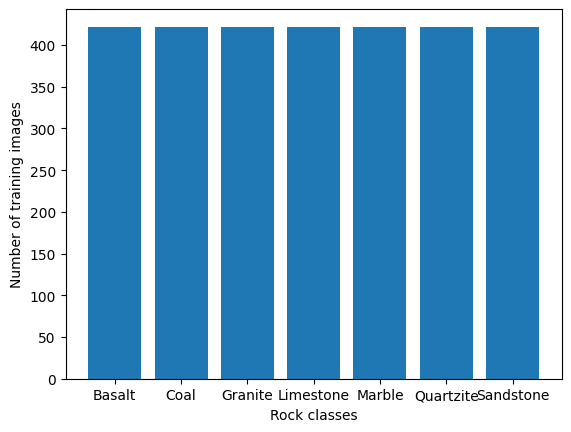

In [41]:
aug_data = {}

for folder in os.listdir(OUTPUT_DIR + 'train/'):
    img_path = OUTPUT_DIR + 'train/' + folder + '/'
    aug_data[folder] = len(os.listdir(img_path))

plt.bar(aug_data.keys(), aug_data.values())
plt.ylabel('Number of training images')
plt.xlabel('Rock classes')
plt.show()